In [28]:
# Importing pygimli
import  pygimli                    as     pg
import  pygimli.meshtools          as     mt
from    pygimli.physics            import ert
from    pygimli.physics            import TravelTimeManager
from    pygimli.physics.gravimetry import GravityModelling2D
from    pygimli.physics.traveltime import createRAData
from    PlotHelpers          import *

# Importing auxiliary libraries
import  numpy                      as     np
import  pandas                     as     pd
import  matplotlib.pyplot          as     plt
from    matplotlib.patches         import PathPatch 
import  os
import cmasher                     as cm

%matplotlib qt

# Setting options
seed_val = 420
np.random.seed(seed_val)

#Mapping matrial properties to units
rhomap = [[1,2000], [2,2000], [3,100]]
vmap = [[1,500], [2,4000], [3,3000]]
denmap = [[1,0], [2,0], [3,600]]

class ERT:
    config = ['dd']    # Electrode configurations
    e_start   = -20    # first electrode position
    e_end     = 20     # last electrode position
    n_elecs   = 41     # number of electrodes
    noiselev  = 2.5    # in prozent
    noiseabs  = 1e-6   # in volt = 0.001mV
    save_data = True

class TT:
    sensor_start = -40   # first geophone position
    sensor_end   = 40    # last geophone position
    n_sensors    = 81   # number of geophones
    dshot        = 2     # Distance between shot indices
    noiselev     = 1e-2  # 0.01% noise level very low as only absolute error should contribute
    noiseabs     = 1e-6  # 0.001ms
    save_data    = True

class GRAV:
    sensor_start = -40   # first geophone position
    sensor_end   = 40    # last geophone position
    n_sensors    = 81   # number of stations
    error        = 0.001
    save_data    = True
    
    
# Plotting
c_ert = 'gnuplot'
c_srt = 'viridis'
c_grav = cm.pepper

In [22]:
world = mt.createWorld(start=[-45, 0], end=[45, -15], layers=[-9],
                       marker=1)
rect = mt.createRectangle(start=[-6, -3.5], end=[6, -6.0],
                          marker=3, area=0.1)
rect.rotate([0, 0, 0.15])

geom = world + rect
pg.show(geom, markers=True)
geom_mesh = mt.createMesh(geom, quality=33, area=0.2)

## Gravimetry

In [23]:
pnts_grav = np.array([np.linspace(GRAV.sensor_start,GRAV.sensor_end,GRAV.n_sensors) , np.zeros(GRAV.n_sensors)]).T

fop = GravityModelling2D(mesh=geom_mesh, points=pnts_grav)
dRho = pg.solver.parseMapToCellArray(denmap, geom_mesh)
g = fop.response(dRho)

grav_data = g + np.random.randn(len(g)) * GRAV.error

if GRAV.save_data == True:
    np.save('Synth_grav2.npy', grav_data)

## ERT

In [25]:
for con in ERT.config:
    # Defining ERT measurement schemes
    ERT_scheme = ert.createData(elecs=np.linspace(start=ERT.e_start, stop=ERT.e_end, num=ERT.n_elecs), schemeName=con)
    
    # Create Nodes at electrode positions for improving numerical accuracy
    for s in ERT_scheme.sensors():
        geom.createNode(s + [0.0, -0.2])
    ert_mesh = mt.createMesh(geom, quality=33, area=0.5)
    
    # Simulating data
    ert_data = ert.simulate(ert_mesh, res=rhomap, scheme=ERT_scheme, verbose=True,
                           noiseLevel=ERT.noiselev,noiseAbs=ERT.noiseabs, seed=seed_val)

    # Save the data for further use
    if ERT.save_data == True:
        ert_data.save('Synth_ert_'+con+'2.dat')

relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.02500000870799444 : 0.025102205675739866


## SRT

In [29]:
# Defining TT measurement schemes
TT_scheme = createRAData(np.linspace(TT.sensor_start, TT.sensor_end, TT.n_sensors),shotDistance=TT.dshot) 

# Create Nodes at electrode positions for improving numerical accuracy
for s in TT_scheme.sensors():
    geom.createNode(s + [0.0, -0.2])
tt_mesh = mt.createMesh(geom, quality=33, area=0.5)

# Assign velocity to nodes
vp = np.array(tt_mesh.cellMarkers())
vp[vp == vmap[0][0]] = vmap[0][1]
vp[vp == vmap[1][0]] = vmap[1][1]
vp[vp == vmap[2][0]] = vmap[2][1]

# Simulating data
mgr_tt = TravelTimeManager()
tt_data = mgr_tt.simulate(slowness=1.0/vp, scheme=TT_scheme, mesh=tt_mesh,
                    noiseLevel=TT.noiselev, noiseAbs=TT.noiseabs, seed=seed_val,
                    verbose=True)
# Save for further use
if TT.save_data == True:
    tt_data.save('Synth_tt2.dat')

27/07/23 - 10:25:15 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


min/max t: 0.0018749999999999997 0.0560410640194893


## Figures

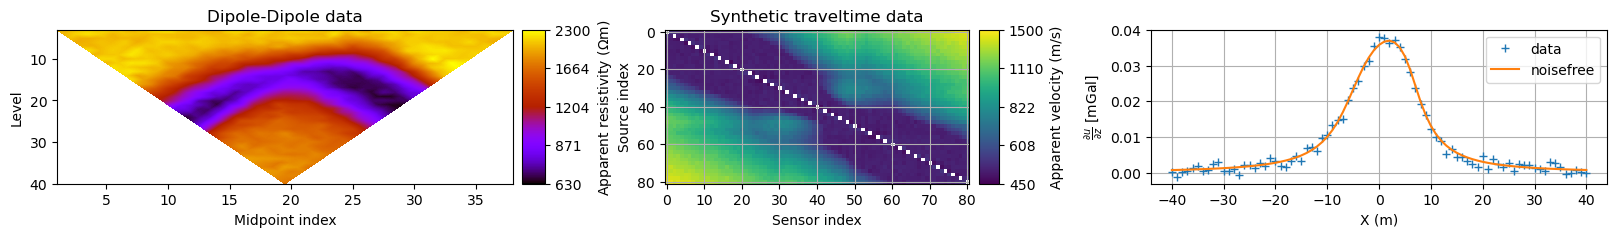

In [30]:
from    pygimli.viewer.mpl      import createColorBarOnly
lim = [round(min(ert_data['rhoa']), -1)-10, round(max(ert_data['rhoa']), -2)] # Pseudosection limits

%matplotlib inline

fig, ax = plt.subplots(1,3,figsize=(20,2))
showPseudosections(ert_data, ert_data['rhoa'].array(), [0,len(ert_data['a'])], 1, ax=ax[0], cmap='gnuplot', clim=lim, annotation=False, colorBar=False)
ax[0].set_title('Dipole-Dipole data')

cax = ax[0].inset_axes([1.02, 0, 0.05, 1])
createColorBarOnly(ax=cax, cMin=lim[0], cMax=lim[1], logScale=True,cMap='gnuplot',
                              label=pg.unit('rhoa'), orientation='vertical')


# Inspecting TT data
mgr_tt.showData(tt_data,ax=ax[1],orientation="vertical", cMap=c_srt, cMin=450, cMax=1500)
ax[1].set_xlabel('Sensor index')
ax[1].set_ylabel('Source index')
ax[1].set_title('Synthetic traveltime data')

# Inspecting GRAV data
ax[2].plot(pnts_grav[:,0], grav_data, "+", label="data")
ax[2].plot(pnts_grav[:,0], g, "-", label="noisefree")
ax[2].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[2].set_xlabel('X (m)')
ax[2].grid()
ax[2].legend()


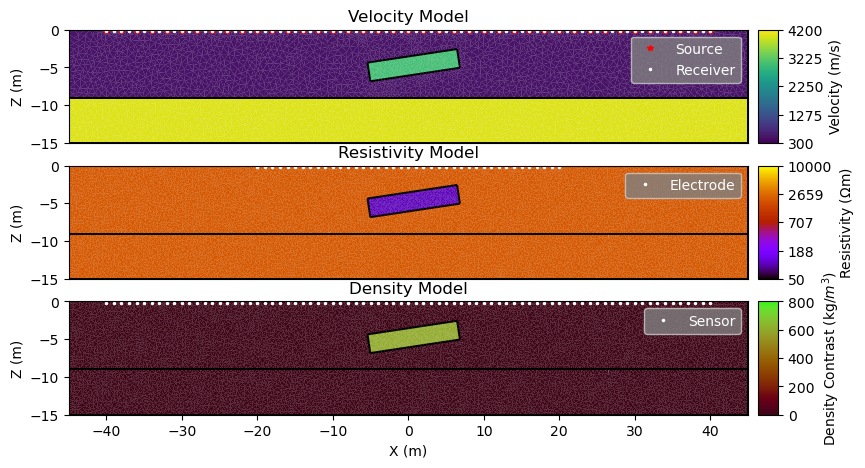

In [31]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(10,5))   
ax1.set_ylabel('Z (m)')
ax2.set_ylabel('Z (m)')
ax3.set_ylabel('Z (m)')
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xlabel('X (m)')
ax1.set_title('Velocity Model')
ax2.set_title('Resistivity Model')
ax3.set_title('Density Model')

# SRT
pg.show(tt_mesh, ax=ax1, data = vp, label = pg.unit('vel'),  orientation='vertical',
        colorBar =True, logScale=False, cMap=c_srt, cMin=300, cMax=4200)
ax1.plot(TT_scheme.sensors()[::TT.dshot,0],TT_scheme.sensors()[::TT.dshot,1]-0.2, 'r*', markersize=4, label='Source')
ax1.plot(TT_scheme.sensors()[:,0],TT_scheme.sensors()[:,1]-0.2, 'w.', markersize=3, label='Receiver')

#ERT
pg.show(geom_mesh, ax=ax2, data = rhomap, label = pg.unit('res'), orientation='vertical',
        colorBar =True, logScale=True,cMap=c_ert, cMin=50, cMax=10000)
ax2.plot(np.linspace(ERT.e_start,ERT.e_end,ERT.n_elecs)[::1],
        np.ones(len(np.linspace(ERT.e_start,ERT.e_end,ERT.n_elecs)[::1]))*(-0.2),'w.', markersize=3, label='Electrode')

#GRAV
pg.show(geom_mesh, ax=ax3, data = denmap, label ='Density Contrast (kg/$m^3$)', orientation='vertical',
        colorBar =True, logScale=False,cMap=c_grav, cMin=0, cMax=800)
ax3.plot(pnts_grav[:,0],pnts_grav[:,1]-0.2,'w.', markersize=3, label='Sensor')

ax1.legend(labelcolor='white', facecolor='gray')
ax2.legend(labelcolor='white', facecolor='gray')
ax3.legend(labelcolor='white', facecolor='gray')